In [58]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers

import sys
sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

In [2]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

band_wavelengths = [442, 492, 559, 665, 704, 739, 779, 833, 864, 943, 1610, 2186]

In [97]:
data_dir = '../data/training_sites'

with open(os.path.join(data_dir, "positive_data_toa.pkl"), 'rb') as file:
    positive = pickle.load(file)
    
with open(os.path.join(data_dir, "negative_data_toa.pkl"), 'rb') as file:
    negative = pickle.load(file)
    
data = np.concatenate((positive, negative))

In [99]:
band_names = list(band_descriptions.keys())

In [161]:
pd.DataFrame(data, columns=band_names).corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12
B1,1.00,0.79,0.75,0.76,0.74,0.02,-0.11,-0.12,-0.13,-0.04,0.54,0.66
B2,0.79,1.00,0.97,0.93,0.82,0.09,-0.05,-0.04,-0.08,0.01,0.58,0.70
B3,0.75,0.97,1.00,0.94,0.88,0.24,0.09,0.11,0.07,0.08,0.63,0.69
B4,0.76,0.93,0.94,1.00,0.91,0.06,-0.09,-0.08,-0.11,0.07,0.69,0.81
B5,0.74,0.82,0.88,0.91,1.00,0.34,0.18,0.17,0.16,0.23,0.81,0.82
B6,0.02,0.09,0.24,0.06,0.34,1.00,0.98,0.94,0.97,0.42,0.39,0.05
B7,-0.11,-0.05,0.09,-0.09,0.18,0.98,1.00,0.96,0.99,0.38,0.28,-0.09
B8,-0.12,-0.04,0.11,-0.08,0.17,0.94,0.96,1.00,0.96,0.41,0.29,-0.07
B8A,-0.13,-0.08,0.07,-0.11,0.16,0.97,0.99,0.96,1.00,0.39,0.30,-0.08
B9,-0.04,0.01,0.08,0.07,0.23,0.42,0.38,0.41,0.39,1.00,0.28,0.16


In [216]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
reduced = PCA(n_components=1).fit_transform(data[:, 1:4])

In [224]:
pd.DataFrame(np.array([data[:,7], reduced[:,0]]).T, columns=['B8', 'RGB']).corr()

,B8,RGB
B8,1.000000,-0.024296
RGB,-0.024296,1.000000


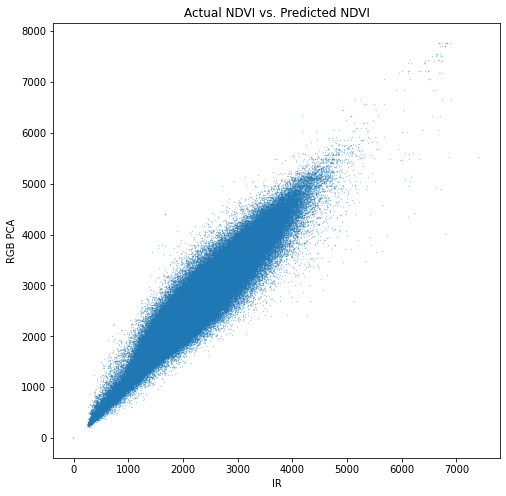

In [235]:
plt.figure(figsize=(8,8), facecolor=(1,1,1))
plt.scatter(data[:,7], data[:,8], s=0.1, alpha=0.5)
plt.plot([0, 1], [0, 1], c='r', alpha=0.4)
#plt.xlim((0,0.8))
#plt.ylim((0,0.8))
plt.ylabel('RGB PCA')
plt.xlabel('IR')
plt.title('Actual NDVI vs. Predicted NDVI')
plt.show()

In [162]:
source = data[:,1:4] / 5000
target = (data[:,7] - data[:,3]) / (data[:,7] + data[:,3])
x, y = shuffle(source, target, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [163]:
input_shape = np.shape(x_train[0])
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="linear"),
    ]
)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_45 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
__________________________________________________

In [171]:
model.compile(loss="mse", 
              optimizer="adam", 
              metrics=["mse", keras.metrics.RootMeanSquaredError()]
             )

In [172]:
batch_size = 128
epochs = 50
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data = (x_test, y_test)
         )

Epoch 1/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0116 - mse: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0082 - val_mse: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 2/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0088 - mse: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0084 - val_mse: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 3/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0085 - mse: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0081 - val_mse: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 4/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0084 - mse: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0080 - val_mse: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 5/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0083 - mse: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0083 - val_mse: 0.0083 - val_ro

Epoch 41/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0077 - mse: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0076 - val_mse: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 42/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0077 - mse: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0077 - val_mse: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 43/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0077 - mse: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0084 - val_mse: 0.0084 - val_root_mean_squared_error: 0.0914
Epoch 44/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0077 - mse: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0080 - val_mse: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 45/50
2945/2945 [==============================] - 4s 1ms/step - loss: 0.0077 - mse: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0095 - val_mse: 0.0095 - v

In [179]:
# Enter rect width in degrees (0.035 max recommended) and site coordinates
rect_width = 0.025
site_coords = [115.350242, -8.562121]
name = 'temesi'
start_date = '2019-01-01'
patch_history = get_history([site_coords], 
                            [name], 
                            rect_width,
                            num_months = 12,
                            start_date = start_date)

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:03<00:40,  3.71s/it]

 17%|█▋        | 2/12 [00:33<01:56, 11.67s/it]

 25%|██▌       | 3/12 [00:37<01:24,  9.37s/it]

 33%|███▎      | 4/12 [00:42<01:03,  7.97s/it]

 42%|████▏     | 5/12 [00:46<00:47,  6.75s/it]

 50%|█████     | 6/12 [00:51<00:36,  6.11s/it]

 58%|█████▊    | 7/12 [01:01<00:37,  7.42s/it]

 67%|██████▋   | 8/12 [01:04<00:24,  6.04s/it]

 75%|███████▌  | 9/12 [01:11<00:19,  6.38s/it]

 83%|████████▎ | 10/12 [01:15<00:11,  5.61s/it]

 92%|█████████▏| 11/12 [01:18<00:04,  4.97s/it]

100%|██████████| 12/12 [01:22<00:00,  6.86s/it]


In [180]:
site_data = patch_history['2019-06-01']['temesi']
rgb = np.stack((site_data['B4'], site_data['B3'], site_data['B2']), axis=-1)
ndvi = (site_data['B8'] - site_data['B4']) / (site_data['B8'] + site_data['B4'])

In [181]:
test = np.stack((site_data['B2'].flatten(), site_data['B3'].flatten(), site_data['B4'].flatten()), axis=-1)

In [182]:
width, height = site_data['B4'].shape

In [186]:
(pred_ndvi).min()

-0.15644187

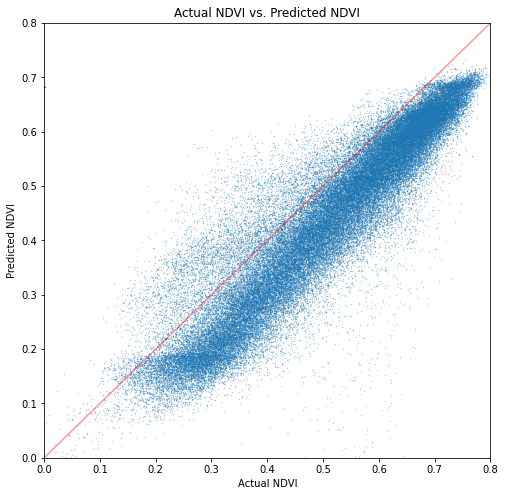

In [215]:
plt.figure(figsize=(8,8), facecolor=(1,1,1))
plt.scatter(ndvi, pred_ndvi, s=0.1, alpha=0.5)
plt.plot([0, 1], [0, 1], c='r', alpha=0.4)
plt.xlim((0,0.8))
plt.ylim((0,0.8))
plt.ylabel('Predicted NDVI')
plt.xlabel('Actual NDVI')
plt.title('Actual NDVI vs. Predicted NDVI')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


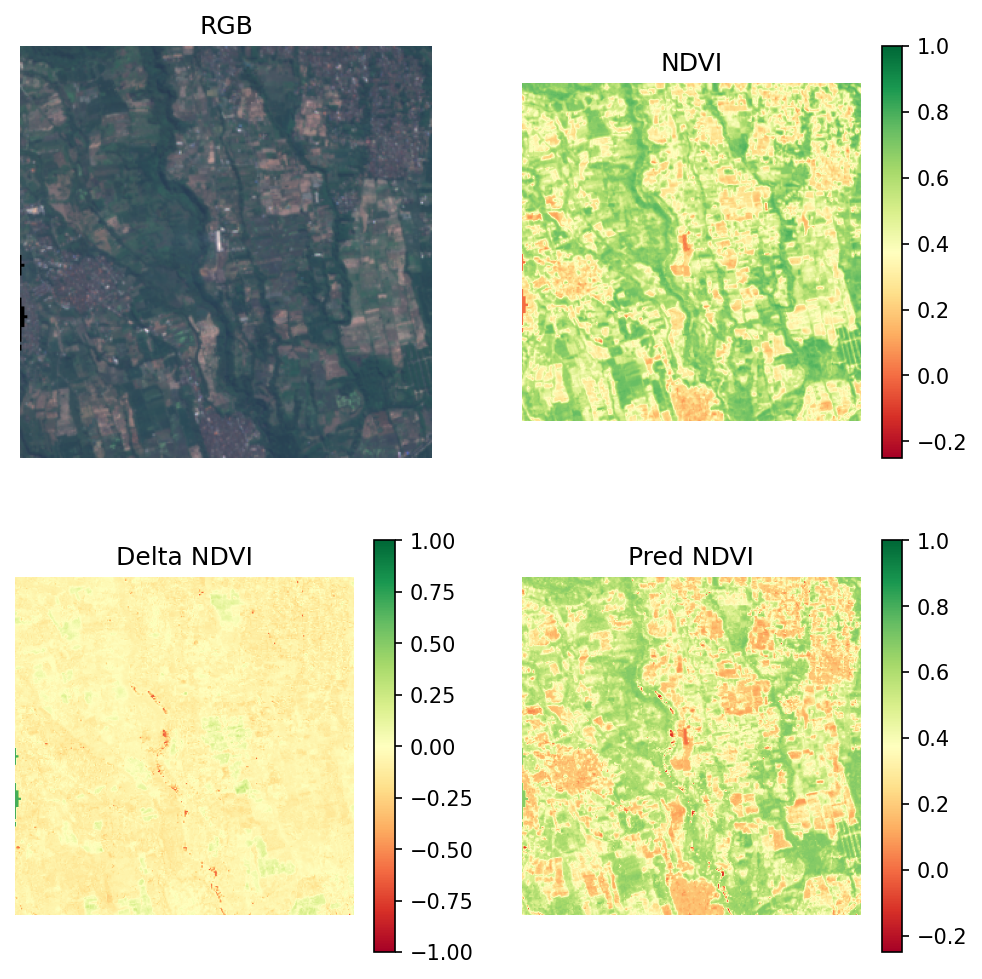

In [209]:
plt.figure(figsize=(8,8), dpi=150)
plt.subplot(2,2,1)
plt.imshow((rgb / 3000), vmin=0, vmax=1)
plt.title('RGB')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-0.25, vmax=1)
plt.title('NDVI')
plt.colorbar()
plt.axis('off')
plt.subplot(2,2,3)
pred_ndvi = model.predict(test / 5000)[:,0].reshape(width, width)
plt.imshow(pred_ndvi - ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Delta NDVI')
plt.colorbar()
plt.axis('off')
plt.subplot(2,2,4)
pred_ndvi = model.predict(test / 5000)[:,0].reshape(width, width)
plt.imshow(pred_ndvi, cmap='RdYlGn', vmin=-0.25, vmax=1)
plt.title('Pred NDVI')
plt.colorbar()
plt.axis('off')
plt.show()

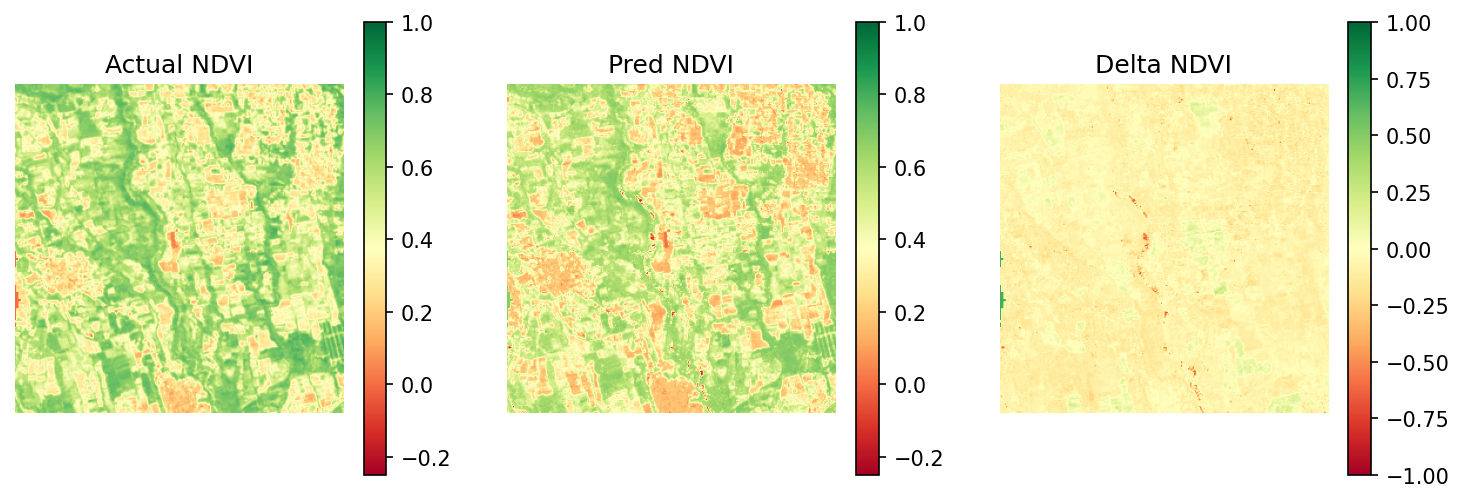

In [214]:
plt.figure(figsize=(12,4), dpi=150, facecolor=(1,1,1))
plt.subplot(1,3,1)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-0.25, vmax=1)
plt.title('Actual NDVI')
plt.colorbar()
plt.axis('off')

plt.subplot(1,3,2)
pred_ndvi = model.predict(test / 5000)[:,0].reshape(width, width)
plt.imshow(pred_ndvi, cmap='RdYlGn', vmin=-0.25, vmax=1)
plt.title('Pred NDVI')
plt.colorbar()
plt.axis('off')
plt.subplot(1,3,3)

pred_ndvi = model.predict(test / 5000)[:,0].reshape(width, width)
plt.imshow(pred_ndvi - ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Delta NDVI')
plt.colorbar()
plt.axis('off')

plt.show()

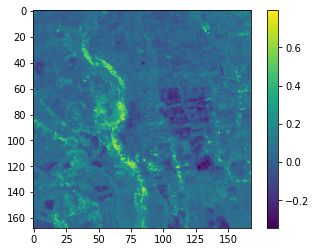

In [106]:
plt.imshow(ndvi - pred_ndvi)
plt.colorbar()
plt.show()